In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from skorch import NeuralNetClassifier
from confused import make_confusion_matrix

from statistics import mean, stdev
import random

from features import generate_final_dataset, gen_rawData, load_data_paths, getInputVector, segment_df, concatenator, plot_confusion_matrix

In [2]:
TRAIN_FILEPATH = "./capstone_data/train/*.csv"
TEST_FILEPATH = "./capstone_data/test/*.csv"

DANCE_MOVES = ["jamesbond", "dab", "mermaid"]
IN_FEATURES = 480
OUT_FEATURES = 3
HIDDEN_LAYER_1_NODES = 80
HIDDEN_LAYER_2_NODES = 40
K = 3   
EPOCHS = 50
TRAIN_BATCH_SIZE = 108
LEARNING_RATE = 0.01
NUM_TO_DANCE_MAP = {0: 'dab', 1: 'jamesbond', 2: 'mermaid'}

In [3]:
# test
test_dic = generate_final_dataset(gen_rawData(load_data_paths(TEST_FILEPATH)))
data_test, lbl_test = segment_df(concatenator(test_dic), "target")
testing_X = getInputVector(data_test)
print(f"testing_X input vector shape : {testing_X.shape}")
print(f"labels for test shape: {lbl_test.shape}")

# train
train_dic = generate_final_dataset(gen_rawData(load_data_paths(TRAIN_FILEPATH)))
data_train, lbl_train = segment_df(concatenator(train_dic), "target")
training_X = getInputVector(data_train)
print(f"training_X input vector shape : {training_X.shape}")
print(f"labels for train shape: {lbl_train.shape}")

X_train = torch.FloatTensor(training_X)
X_test = torch.FloatTensor(testing_X)
y_train = torch.LongTensor(lbl_train)
y_test = torch.LongTensor(lbl_test)

testing_X input vector shape : (538, 480)
labels for test shape: (538,)
training_X input vector shape : (2698, 480)
labels for train shape: (2698,)


In [4]:
def fold_trainer(model, x,y, name):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        scores.append(model.score(x_test_fold, y_test_fold))
    print(f"-------------------------{name}--------------------------------")
    print()
    print('List of possible accuracy:', scores)
    print(f"\nMaximum Accuracy That can be obtained from {name} is:", max(scores)*100, '%')
    print('\nMinimum Accuracy:',min(scores)*100, '%')
    print('\nOverall Accuracy:',mean(scores)*100, '%')
    print('\nStandard Deviation is:', stdev(scores))
    print(f"---------------------------------------------------------------")
    print()

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, in_features = IN_FEATURES, h1= HIDDEN_LAYER_1_NODES, h2 = HIDDEN_LAYER_2_NODES, out_features = OUT_FEATURES):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [6]:
torch.manual_seed(0)
net = NeuralNetClassifier(
    NeuralNet,
    max_epochs=EPOCHS,
    lr=LEARNING_RATE,
    batch_size=TRAIN_BATCH_SIZE,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    train_split=None
)
exClf = ExtraTreesClassifier(n_estimators=100, random_state=0)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')
knn = KNeighborsClassifier()

In [7]:
vc = VotingClassifier(estimators = [('svm',poly),('net',net),('exClf',exClf), ('knn', knn)], voting='hard')
fold_trainer(vc,X_train,y_train,"Voting-Classifier")

  epoch    train_loss     dur
-------  ------------  ------
      1        1.0862  0.0333
      2        0.6279  0.0588
      3        0.4299  0.0626
      4        0.3155  0.0580
      5        0.1823  0.0509
      6        0.1160  0.0556
      7        0.2102  0.0753
      8        0.2558  0.0603
      9        0.1810  0.0814
     10        0.0789  0.0446
     11        0.0539  0.0406
     12        0.0332  0.0525
     13        0.0304  0.0596
     14        0.0228  0.0511
     15        0.0172  0.1461
     16        0.0157  0.0487
     17        0.0144  0.0448
     18        0.0134  0.0597
     19        0.0123  0.0490
     20        0.0110  0.0595
     21        0.0101  0.0560
     22        0.0090  0.0473
     23        0.0082  0.0534
     24        0.0069  0.0454
     25        0.0059  0.0505
     26        0.0052  0.0463
     27        0.0045  0.0368
     28        0.0039  0.0523
     29        0.0030  0.0645
     30        0.0016  0.0516
     31        0.0011  0.0565
     32   

      9        0.0374  0.0609
     10        0.0262  0.0523
     11        0.0200  0.0406
     12        0.0156  0.0411
     13        0.0136  0.0430
     14        0.0125  0.0440
     15        0.0118  0.0542
     16        0.0110  0.0600
     17        0.0103  0.0429
     18        0.0097  0.0426
     19        0.0095  0.0442
     20        0.0092  0.0575
     21        0.0091  0.0453
     22        0.0090  0.0518
     23        0.0089  0.0545
     24        0.0088  0.0392
     25        0.0088  0.0499
     26        0.0087  0.0558
     27        0.0087  0.0445
     28        0.0087  0.0475
     29        0.0086  0.0810
     30        0.0086  0.0419
     31        0.0086  0.0534
     32        0.0086  0.0429
     33        0.0085  0.0465
     34        0.0085  0.0748
     35        0.0085  0.0425
     36        0.0085  0.0483
     37        0.0085  0.0615
     38        0.0085  0.0460
     39        0.0084  0.0511
     40        0.0084  0.0504
     41        0.0084  0.0546
     42   

     18        0.0091  0.0542
     19        0.0088  0.0490
     20        0.0085  0.0428
     21        0.0082  0.0368
     22        0.0080  0.0557
     23        0.0078  0.0537
     24        0.0077  0.0461
     25        0.0075  0.0510
     26        0.0072  0.0416
     27        0.0068  0.0474
     28        0.0067  0.0436
     29        0.0065  0.0491
     30        0.0064  0.0384
     31        0.0064  0.0457
     32        0.0063  0.0366
     33        0.0063  0.0361
     34        0.0063  0.0474
     35        0.0062  0.0589
     36        0.0062  0.0554
     37        0.0062  0.0390
     38        0.0061  0.0411
     39        0.0061  0.1025
     40        0.0061  0.1089
     41        0.0061  0.0463
     42        0.0061  0.0572
     43        0.0061  0.0539
     44        0.0061  0.0992
     45        0.0060  0.0556
     46        0.0060  0.0437
     47        0.0060  0.0387
     48        0.0060  0.0624
     49        0.0060  0.0468
     50        0.0060  0.0433
  epoch   

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       182
           1       0.99      0.96      0.97       180
           2       1.00      0.90      0.95       176

    accuracy                           0.95       538
   macro avg       0.96      0.95      0.95       538
weighted avg       0.95      0.95      0.95       538

torch.Size([538, 480])


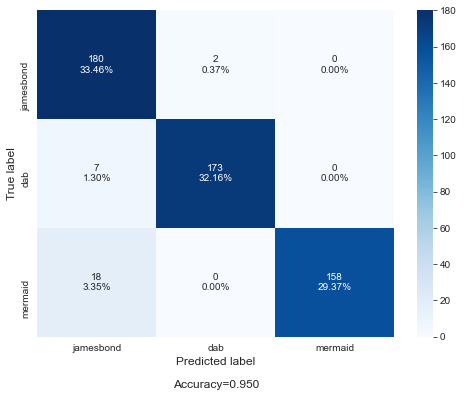

In [8]:
y_preds = vc.predict(X_test)
print(classification_report(lbl_test, y_preds))
cmt = confusion_matrix(lbl_test, y_preds)
make_confusion_matrix(cmt,categories=DANCE_MOVES, figsize=(8,6))
print(X_test.shape)

In [9]:
# testing with a random sample from test set 
random.seed(69)
random_int = random.randint(0, len(testing_X))
random_input = np.asarray(testing_X[random_int]).reshape(-1,480)
print(random_input.shape)

(1, 480)


In [10]:
def getPrediction(arr):
    out = vc.predict(arr)
    return NUM_TO_DANCE_MAP[out[0]]

In [11]:
getPrediction(random_input)

'mermaid'